In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## HP Rankings

In [3]:
# Load HP data
hp_df = pd.read_csv('../Week3/HP/team_stats.csv')

# Filter for relevant teams
relevant_teams = ['Q9', 'OUG', 'SPG', 'XROCK', 'GodL', 'Wolves']

# Add win pct column
win_pct = {
    'Q9': 0.538,
    'OUG': 0.800,
    'SPG': 0.333,
    'XROCK': 0.153,
    'GodL': 0.600,
    'Wolves': 0.818,
}

# Multiply 'WinPct' by 100 for percentage format
hp_df['WinPct'] = hp_df['Team'].map(win_pct) * 100
hp_df.to_csv('../rankings/hp_team_stats.csv', index=False)

# Select relevant columns
stats = ['RotationWin', 'BreakSuccess', 'ControlSharePct', 'AvgScoreDiff', 'WinPct']

hp_df = hp_df[['Team'] + stats]

hp_df

,Team,RotationWin,BreakSuccess,ControlSharePct,AvgScoreDiff,WinPct
0,Wolves,47.169811,47.916667,34.892739,31.444444,81.8
1,OUG,47.297297,40.298507,32.121749,37.250000,80.0
2,GodL,48.148148,34.782609,30.733333,72.333333,60.0
3,Q9,43.396226,25.000000,25.688705,-12.714286,53.8
4,XROCK,40.000000,21.739130,22.930108,-58.590909,15.3
5,SPG,29.687500,18.000000,21.849415,-10.250000,33.3


In [4]:
# Standardize stats
# stats = ['RotationWin', 'BreakSuccess', 'ControlSharePct', 'AvgScoreDiff', 'WinPct']
scaler = StandardScaler()
hp_scaled = pd.DataFrame(scaler.fit_transform(hp_df[stats]), columns=stats)

# Assign weights
weights = {
    'WinPct': 0.20,
    'ControlSharePct': 0.20,
    'RotationWin': 0.20,
    'BreakSuccess': 0.20,
    'AvgScoreDiff': 0.20
}

# Calculate weighted score
hp_df['HPRanking'] = sum(hp_scaled[stat] * weight for stat, weight in weights.items())

# Sort by WeightedScore
hp_df = hp_df.sort_values(by='HPRanking', ascending=False, ignore_index=True)

hp_rankings = hp_df[['Team', 'HPRanking']].reset_index(drop=True)
print(hp_rankings)

     Team  HPRanking
0  Wolves   1.072551
1     OUG   0.831087
2    GodL   0.694660
3      Q9  -0.300061
4   XROCK  -1.121032
5     SPG  -1.177205


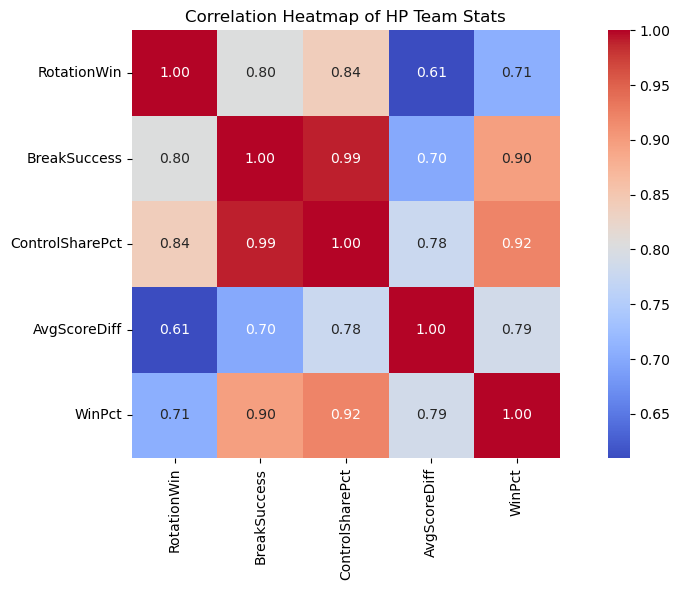

In [5]:
# Correlation between stats and win percentage
correlation_matrix = hp_df[stats].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of HP Team Stats')
plt.tight_layout()

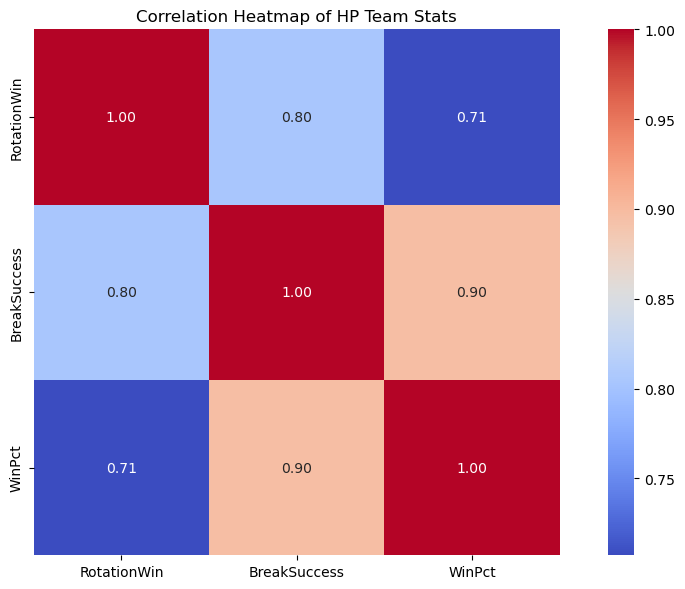

In [6]:
# Correlation between stats and win percentage
correlation_matrix = hp_df[['RotationWin', 'BreakSuccess', 'WinPct']].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of HP Team Stats')
plt.tight_layout()

In [6]:
# Ranking without using WinPct
new_stats = ['RotationWin', 'BreakSuccess', 'ControlSharePct', 'AvgScoreDiff']
scaler = StandardScaler()
new_scaled = pd.DataFrame(scaler.fit_transform(hp_df[new_stats]), columns=new_stats)

# Assign new weights
weights = {
    'ControlSharePct': 0.25,
    'RotationWin': 0.25,
    'BreakSuccess': 0.25,
    'AvgScoreDiff': 0.25
}

# Calculate new weighted score
hp_df['HPRankingNoWinPct'] = sum(new_scaled[stat] * weight for stat, weight in weights.items())

# Sort by new WeightedScore
hp_df = hp_df.sort_values(by='HPRankingNoWinPct', ascending=False, ignore_index=True)
hp_rankings_no_win_pct = hp_df[['Team', 'HPRankingNoWinPct']].reset_index(drop=True)
print(hp_rankings_no_win_pct)

     Team  HPRankingNoWinPct
0  Wolves           1.049553
1    GodL           0.805764
2     OUG           0.766597
3      Q9          -0.372629
4   XROCK          -0.995169
5     SPG          -1.254116


## Control Rankings

In [7]:
import pandas as pd

# Load raw Control rounds (one row per round)
df = pd.read_excel("../Week2/Control/control.xlsx", sheet_name=0)

# Ensure Date is a date (stringify to avoid timezone issues in ID)
df['Date'] = pd.to_datetime(df['Date']).dt.strftime("%Y-%m-%d")

# Build a stable team-pair token (order-free) and a MatchID: Date + Map + Teams
df['TeamPair'] = df.apply(lambda r: " vs ".join(sorted([str(r['Offense']), str(r['Defense'])])), axis=1)
df['MatchID'] = df['Date'] + " | " + df['Map'].astype(str) + " | " + df['TeamPair']

# Count round wins per match per team
round_counts = (
    df.groupby(['MatchID', 'Winner'])
      .size()
      .reset_index(name='RoundWins')
)

# Determine match winner: first to 4 rounds (drop matches with no team reaching 4)
match_winners = (
    round_counts.loc[round_counts.groupby('MatchID')['RoundWins'].idxmax()]
)
match_winners = match_winners[match_winners['RoundWins'] >= 4] \
                             .rename(columns={'Winner': 'MatchWinner'}) \
                             [['MatchID', 'MatchWinner']]

# Find participants for each match
participants = (
    df.groupby('MatchID')
      .apply(lambda g: sorted(set(g['Offense']).union(set(g['Defense']))))
      .reset_index(name='Teams')
)

# Explode to one row per (MatchID, Team)
team_match_rows = participants.explode('Teams').rename(columns={'Teams': 'Team'})

# Games played per team (only include matches that have a decided winner)
decided_matches = team_match_rows[team_match_rows['MatchID'].isin(match_winners['MatchID'])]
games_played = decided_matches.groupby('Team').size().reset_index(name='Games')

# Wins per team: join winners and count when Team == MatchWinner
wins = (
    decided_matches.merge(match_winners, on='MatchID', how='inner')
                   .assign(Win=lambda x: (x['Team'] == x['MatchWinner']).astype(int))
                   .groupby('Team')['Win'].sum()
                   .reset_index(name='Wins')
)

# Win rate = Wins / Games
win_rates = (
    games_played.merge(wins, on='Team', how='left')
                .fillna({'Wins': 0})
                .assign(WinRate=lambda x: x['Wins'] / x['Games'])
                .sort_values(['WinRate', 'Wins', 'Games'], ascending=[False, False, False])
                .reset_index(drop=True)
)

win_rates = win_rates[win_rates['Team'].isin(relevant_teams)].reset_index(drop=True)

win_rates = win_rates[['Team', 'WinRate']]


In [11]:
control_df = pd.read_csv('../Week3/Control/team_stats.csv')

control_df = control_df.merge(win_rates, on='Team', how='left')

control_df['AvgTicksAllowedPerDefRound'] = control_df['AvgTicksAllowedPerDefRound'] * (-1)
control_df['WinRate'] = control_df['WinRate'] * 100  # Convert to percentage format

# Select relevant stats for Control
stats = ['AvgLifeDiff', 'RoundDiff', 'AvgTicksPerOffRound', 'AvgTicksAllowedPerDefRound', 'WinRate']
control_df = control_df[['Team'] + stats]
control_df

,Team,AvgLifeDiff,RoundDiff,AvgTicksPerOffRound,AvgTicksAllowedPerDefRound,WinRate
0,OUG,0.923077,2,3.846154,-2.730769,50.000000
1,Wolves,2.410256,11,2.476190,-2.722222,62.500000
2,GodL,1.900000,2,3.583333,-2.653846,55.555556
3,SPG,-3.613636,-14,2.409091,-3.500000,22.222222
4,Q9,-0.122807,1,2.964286,-2.758621,60.000000
5,XROCK,1.073171,7,3.600000,-3.857143,75.000000


In [12]:
# Standardize stats
scaler = StandardScaler()
control_scaled = pd.DataFrame(scaler.fit_transform(control_df[stats]), columns=stats)

# Assign weights
weights = {
    'WinRate': 0.20,
    'RoundDiff': 0.20,
    'AvgLifeDiff': 0.20,
    'AvgTicksPerOffRound': 0.20,
    'AvgTicksAllowedPerDefRound': 0.20
}
# Calculate weighted score
control_df['ControlRanking'] = sum(control_scaled[stat] * weight for stat, weight in weights.items())

# Sort by WeightedScore
control_df = control_df.sort_values(by='ControlRanking', ascending=False, ignore_index=True)

control_rankings = control_df[['Team', 'ControlRanking']].reset_index(drop=True)

print(control_rankings)

     Team  ControlRanking
0    GodL        0.497660
1  Wolves        0.445346
2     OUG        0.390292
3   XROCK        0.272317
4      Q9        0.057588
5     SPG       -1.663203


In [14]:
control_df.to_csv('../rankings/control_team_stats.csv', index=False)

In [15]:
control_df

,Team,AvgLifeDiff,RoundDiff,AvgTicksPerOffRound,AvgTicksAllowedPerDefRound,WinRate,ControlRanking
0,GodL,1.900000,2,3.583333,-2.653846,55.555556,0.497660
1,Wolves,2.410256,11,2.476190,-2.722222,62.500000,0.445346
2,OUG,0.923077,2,3.846154,-2.730769,50.000000,0.390292
3,XROCK,1.073171,7,3.600000,-3.857143,75.000000,0.272317
4,Q9,-0.122807,1,2.964286,-2.758621,60.000000,0.057588
5,SPG,-3.613636,-14,2.409091,-3.500000,22.222222,-1.663203


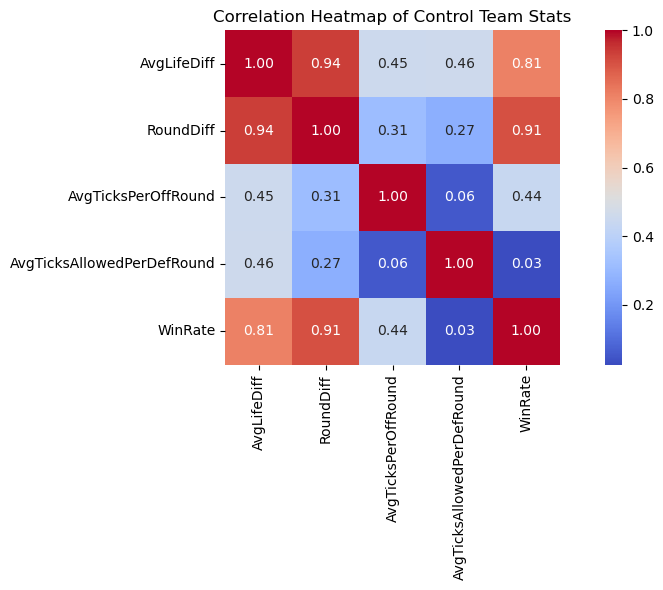

In [16]:
# Correlation between stats and win percentage
correlation_matrix_control = control_df[stats].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_control, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Control Team Stats')
plt.tight_layout()

In [17]:
# Ranking without using WinRate
new_stats = ['AvgLifeDiff', 'RoundDiff', 'AvgTicksPerOffRound', 'AvgTicksAllowedPerDefRound']
scaler = StandardScaler()
new_scaled_control = pd.DataFrame(scaler.fit_transform(control_df[new_stats]), columns=new_stats)

# Assign new weights
weights_control = {
    'RoundDiff': 0.25,
    'AvgLifeDiff': 0.25,
    'AvgTicksPerOffRound': 0.25,
    'AvgTicksAllowedPerDefRound': 0.25
}

# Calculate new weighted score
control_df['ControlRankingNoWinRate'] = sum(new_scaled_control[stat] * weight for stat, weight in weights_control.items())
# Sort by new WeightedScore
control_df = control_df.sort_values(by='ControlRankingNoWinRate', ascending=False, ignore_index=True)
control_rankings_no_win_rate = control_df[['Team', 'ControlRankingNoWinRate']].reset_index(drop=True)
print(control_rankings_no_win_rate)

     Team  ControlRankingNoWinRate
0    GodL                 0.601373
1     OUG                 0.552827
2  Wolves                 0.428901
3   XROCK                 0.019872
4      Q9                -0.017248
5     SPG                -1.585724


## SnD Rankings

In [18]:
# Load the data
snd_df = pd.read_csv('../Week3/SnD/team_stats.csv')

# Add win pct column
win_pct = {
    'Q9': 0.73,
    'OUG': 0.38,
    'SPG': 0.57,
    'XROCK': 0.42,
    'GodL': 0.50,
    'Wolves': 0.58,
}

# Multiply 'WinPct' by 100 for percentage format
snd_df['WinPct'] = snd_df['Team'].map(win_pct) * 100

snd_df.to_csv('../rankings/snd_team_stats.csv', index=False)

In [41]:
# Standardize stats
stats = ['WinPct', 'PlantRate', 'RetakeRate', 'RoundDiff', 'FBRate']
scaler = StandardScaler()
snd_scaled = pd.DataFrame(scaler.fit_transform(snd_df[stats]), columns=stats)

# Assign weights
weights = {
    'WinPct': 0.20,
    'PlantRate': 0.20,
    'RetakeRate': 0.20,
    'RoundDiff': 0.20,
    'FBRate': 0.20
}
# Calculate weighted score
snd_df['SNDRanking'] = sum(snd_scaled[stat] * weight for stat, weight in weights.items())

# Sort by WeightedScore
snd_df = snd_df.sort_values(by='SNDRanking', ascending=False, ignore_index=True)
snd_rankings = snd_df[['Team', 'SNDRanking']].reset_index(drop=True)
print(snd_rankings)

     Team  SNDRanking
0      Q9    1.006075
1     SPG    0.177260
2  Wolves    0.168288
3     OUG   -0.134443
4    GodL   -0.392348
5   XROCK   -0.824832


## Combine Rankings

In [42]:
# Combine rankings into a single DataFrame
combined_rankings = (
    hp_rankings.merge(control_rankings, on='Team', how='outer')
               .merge(snd_rankings, on='Team', how='outer')
)

# Define weights for each ranking
final_weights = {
    'HPRanking': 0.40,
    'ControlRanking': 0.20,
    'SNDRanking': 0.40
}
# Calculate final ranking
combined_rankings['FinalRanking'] = sum(combined_rankings[stat] * weight for stat, weight in final_weights.items())

# Normalize FinalRanking to 50-100 scale
min_rank = combined_rankings['FinalRanking'].min()
max_rank = combined_rankings['FinalRanking'].max()
combined_rankings['FinalRanking'] = 50 + (combined_rankings['FinalRanking'] - min_rank) / (max_rank - min_rank) * 50

# Sort by FinalRanking
combined_rankings = combined_rankings.sort_values(by='FinalRanking', ascending=False, ignore_index=True)

print(combined_rankings)

     Team  HPRanking  ControlRanking  SNDRanking  FinalRanking
0  Wolves   1.072551        0.445346    0.168288    100.000000
1     OUG   0.831087        0.390292   -0.134443     91.324571
2      Q9  -0.300061        0.057588    1.006075     88.942483
3    GodL   0.694660        0.497660   -0.392348     86.155494
4   XROCK  -1.121032        0.272317   -0.824832     50.331421
5     SPG  -1.177205       -1.663203    0.177260     50.000000


In [43]:
combined_rankings.to_csv('../rankings/final_team_rankings.csv', index=False)